In [1]:
import mrcfile

import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

In [3]:
# You will need the two half maps from: https://www.ebi.ac.uk/emdb/EMD-24822

map_1_file = ''
map_2_file = ''

with mrcfile.open(map_1_file) as mrc:
    y1 = mrc.data
    voxel = mrc.voxel_size.x
    mrc.close()
    
with mrcfile.open(map_2_file) as mrc:
    y2 = mrc.data
    mrc.close()    

In [4]:
shape = y1.shape
N = shape[0]
r = N // 2
r_corner = int(np.ceil(np.sqrt(np.sum([s**2 for s in shape]))/2))
r_signal = 115 

rdists = fsc.radial_distance_grid(y1.shape)  

sphere_mask = fsc.sphere_mask(rdists, r_signal)

eps = y1 * ~sphere_mask

ratio = np.sum(~sphere_mask) / y1.size

freq = fsc.get_radial_spatial_frequencies(y1, voxel)

In [5]:
y_whitened = fsc.whitening_transform(y1, eps, r_corner, ratio) 

y_upsample = fsc.fourier_upsample(y_whitened, 2)

In [6]:
fsc_y1y2 = fsc.two_volume_fsc(y1, y2, rmax=r)

sfsc_upsample = np.mean(fsc.single_volume_fsc(y_upsample, rmax=r, n_splits=1, whiten_upsample=True), axis=0)

y1_raps = fsc.compute_spherically_averaged_power_spectrum(y1, r)
eps_raps = fsc.compute_spherically_averaged_power_spectrum(eps, r)

In [7]:
diff_map_noise = (y1 - y2) / np.sqrt(2)

diff_map_raps = fsc.compute_spherically_averaged_power_spectrum(diff_map_noise, r)

In [8]:
# #SSNRs
ssnr_est_diff = (y1_raps - diff_map_raps) / diff_map_raps

ssnr_est_corner = (y1_raps - (eps_raps/ratio)) / (eps_raps/ratio)

ssnr_from_fsc = fsc_y1y2 / (1 - fsc_y1y2)

ssnr_from_sfsc = sfsc_upsample / (1 - sfsc_upsample)


# #FSCs
fsc_est_diff = ssnr_est_diff / ( 1 + ssnr_est_diff)

fsc_est_corners = ssnr_est_corner / (1 + ssnr_est_corner)

/tmp/ipykernel_2736606/2066132469.py:6: RuntimeWarning: divide by zero encountered in true_divide
  ssnr_from_fsc = fsc_y1y2 / (1 - fsc_y1y2)


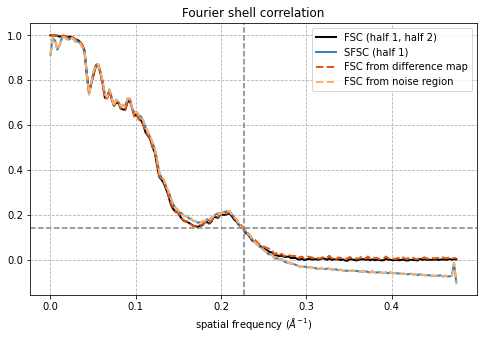

In [9]:
plt.figure(figsize=(8,5))
plt.plot(freq, fsc_y1y2, color='k', linewidth=2, label='FSC (half 1, half 2)')
plt.plot(freq, sfsc_upsample, color=cmap_a[0], linewidth=2, label='SFSC (half 1)')
plt.plot(freq, fsc_est_diff, color=cmap_a[1], linewidth=2, linestyle='--', label='FSC from difference map')
plt.plot(freq, fsc_est_corners, color=cmap_b[1], linewidth=2, linestyle='--', label='FSC from noise region')
plt.grid(which='major', linestyle='--')
plt.title('Fourier shell correlation')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.axhline(1/7, color='grey', linestyle='--')
plt.axvline(1/4.4, color='grey', linestyle='--')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.legend()
# plt.savefig('')
plt.show()

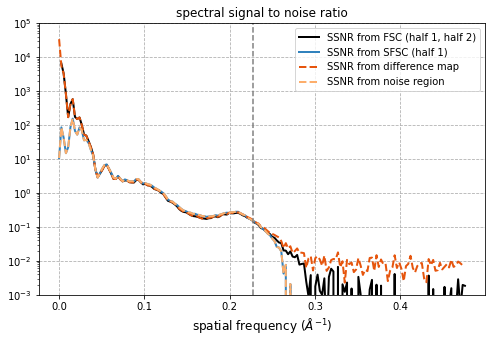

In [10]:
plt.figure(figsize=(8,5))
plt.semilogy(freq, ssnr_from_fsc, color='k', linewidth=2, label='SSNR from FSC (half 1, half 2)')
plt.semilogy(freq, ssnr_from_sfsc, color=cmap_a[0], linewidth=2, label='SSNR from SFSC (half 1)')
plt.semilogy(freq, ssnr_est_diff, color=cmap_a[1], linewidth=2, linestyle='--', label='SSNR from difference map')
plt.semilogy(freq, ssnr_est_corner, color=cmap_b[1], linewidth=2, linestyle='--', label='SSNR from noise region')
plt.title('spectral signal to noise ratio')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.grid(which='major', linestyle='--')
plt.axvline(1/4.4, color='grey', linestyle='--')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.ylim(1e-3, 1e5)
plt.legend()
# plt.savefig('')
plt.show()

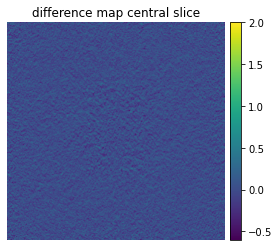

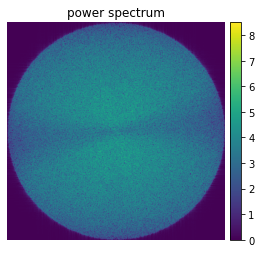

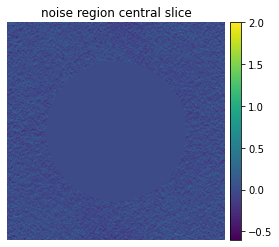

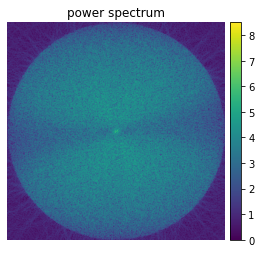

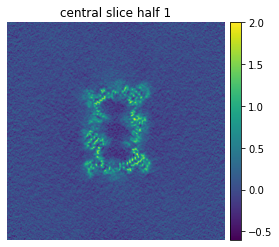

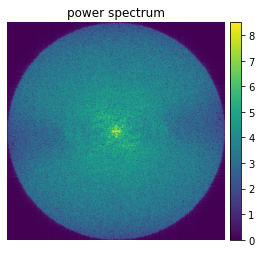

In [11]:
plt.figure(figsize=(5,4))
plt.imshow(diff_map_noise[...,N//2], vmin=-0.6, vmax=2)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('difference map central slice')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(diff_map_noise[...,N//2])), vmin=0, vmax=8.5)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('power spectrum')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(eps[...,N//2], vmin=-0.6, vmax=2)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('noise region central slice')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(eps[...,N//2])), vmin=0, vmax=8.5)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('power spectrum')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(y1[...,N//2], vmin=-0.6, vmax=2)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('central slice half 1')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(y1[...,N//2])), vmin=0, vmax=8.5)
plt.axis('off')
plt.colorbar(pad=0.02)
plt.title('power spectrum')
# plt.savefig('')
plt.show()